In [2]:
from CAENpy.CAENDigitizer import CAEN_DT5740_Digitizer
import numpy as np
import matplotlib.pyplot as plt
import h5py, sys, os, pickle, time
sys.path.append("../../arduino_stages")
import stage_control as sc
sys.path.append("../InstekPPX10005")
import instekPPX10005 as vs

In [3]:
instek = vs.open()
vs.set_output(instek, 'off')
vs.set_voltage(instek, 6.5)

In [4]:
def do_move_stage(x_mm,y_mm):
    ## move stage (x,y in mm)
    vs.set_output(instek, 'on')
    time.sleep(0.1)
    if(not vs.get_output(instek)):
        return False
    
    success=sc.move_stage(x_mm,y_mm)
    nmm = np.max(np.abs([x_mm, y_mm]))
    time.sleep(10*nmm)
    vs.set_output(instek, 'off')

    return success

In [5]:
do_move_stage(0,0)

Moving by dX, dY: 0.0 mm, 0.0mm


True

In [6]:
digitizer = CAEN_DT5740_Digitizer(0) # Open the connection.

print(digitizer.idn) # Print general info about the digitizer.

CAEN DT5740D digitizer, serial number 31030


In [7]:
def configure_digitizer(digitizer, dc_offset_list, trig_level_list):

	enable_list = [True, True, True, False]  ## groups of 8 channels (1-8, 9-16, 17-24, 25-32)

	digitizer.set_record_length(128)
	digitizer.set_post_trigger_size(50) ## in percent
	digitizer.set_max_num_events_BLT(1023)
	digitizer.set_acquisition_mode('sw_controlled')
	digitizer.set_ext_trigger_input_mode('disabled')
	digitizer.enable_channels(enable_list)

	for i in range(4): ##loop over groups
		bloffset = int((1-dc_offset_list[i]) * 2**16)
		digitizer.set_group_DC_offset(i, DAC=bloffset)
		triglev = dc_offset_list[i]*2**12 + trig_level_list[i]
		digitizer.setup_trigger(i, int(triglev))
		digitizer.set_trigger_polarity(channel=i, edge='rising') 


In [7]:
#digitizer.stop_acquisition()

In [8]:
def take_N_files_CAEN(Nfiles, time_per_file=1, path = "", file_name="", save_data=False, make_plot=True):

	dc_offset_list = [0.5, 0.5, 0.5, 0.5] ## list of dc offsets (fractional range 0-1)
											## e.g. if you want baseline at 25% of max ADC, set 0.25 here
	trig_level_list = [150, 150, 150, 2000] ## list of trig levels in ADC counts above the baseline
											## e.g. if you 100 ADC counts above baseline, set 100 here

	# Now configure the digitizer:
	configure_digitizer(digitizer, dc_offset_list, trig_level_list)

	# Now enter into acquisition mode using the `with` statement:

	fsample = 62.5e6 ## sampling rate in Hz
	record_length = 129 ## not clear why this differs from the 128 set above
	time_vec = np.arange(0, record_length/fsample, 1/fsample)


	for n in range(Nfiles):
		print("Working on file %d of %d"%(n+1, Nfiles))

		digitizer.start_acquisition(acq_time=time_per_file)
		waveforms = digitizer.get_waveforms()
		digitizer.stop_acquisition()

		if(save_data):
			if("%d" in file_name):
				fnameout = os.path.join(path, file_name%n)
			else:
				fnameout = os.path.join(path, file_name)
			with open(fnameout, 'wb') as fout:
				pickle.dump(waveforms, fout)

		if(make_plot and n == 0):
			plt.figure(figsize=(24,3))
			max_plot = 5
			step = int(len(waveforms)/max_plot)
			for wf in waveforms[::step]:
				sum_waveform = np.zeros_like(time_vec)	
				for j, ch in enumerate(range(16,-1,-2)):

					## subtract baseline
					baseline = 2048 #np.median(wf[ch][:20])

					plt.subplot(1,10,j+1)
					plt.plot(time_vec*1e6, wf[ch]-baseline)
					plt.ylim(-100, 1000)
					if(j > 0): 
						plt.gca().set_yticklabels([])
					else:
						plt.ylabel("Amplitude [ADC units]")
					plt.title("Channel %d"%(j+1))
					plt.xlabel("Time [us]")

					gidx = int(j/4)
					trig_lev = dc_offset_list[gidx]*2**12 + trig_level_list[gidx] - baseline
					plt.plot(time_vec*1e6, np.ones_like(time_vec)*trig_lev, 'k:')
					sum_waveform += (wf[ch] - baseline)

				plt.subplot(1,10,10)
				plt.plot(time_vec*1e6, sum_waveform)
				plt.ylim(-100, 10000)
				plt.gca().set_yticklabels([])
				plt.title("Sum")
				plt.xlabel("Time [us]")

			plt.subplots_adjust(wspace=0)
			plt.show()

Working on file 1 of 1
Reading 1023 events....


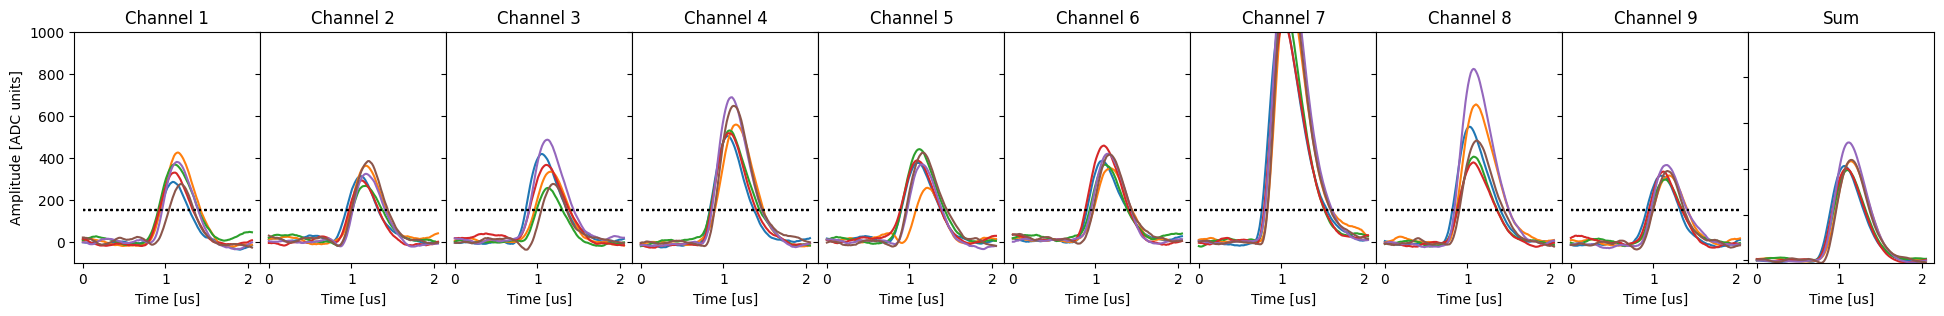

In [9]:
take_N_files_CAEN(1, time_per_file=1, make_plot=True, save_data=False)

Moving to: (x,y) =  -6.0 1.0 , by: (dx, dy) = 0.0 1.0
Moving by dX, dY: 0.0 mm, 1.0mm
Working on file 1 of 10
Reading 1023 events....


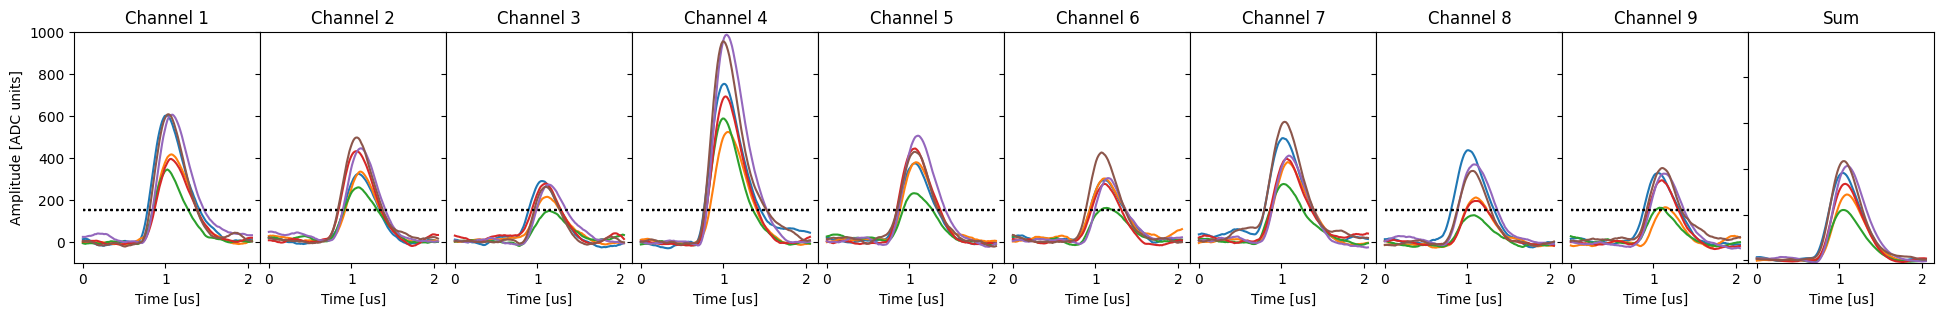

Working on file 2 of 10
Reading 1023 events....
Working on file 3 of 10
Reading 1023 events....
Working on file 4 of 10
Reading 1023 events....
Working on file 5 of 10
Reading 1023 events....
Working on file 6 of 10
Reading 1023 events....
Working on file 7 of 10
Reading 1023 events....
Working on file 8 of 10
Reading 1023 events....
Working on file 9 of 10
Reading 1023 events....
Working on file 10 of 10
Reading 1023 events....
Moving to: (x,y) =  -6.0 2.0 , by: (dx, dy) = 0.0 1.0
Moving by dX, dY: 0.0 mm, 1.0mm
Working on file 1 of 10
Reading 1023 events....


In [9]:
Nfiles = 10
save_data = True
make_plot = True
path = "D:/data/SiPM/waveforms/20240506/pos_scan_grid/"


curr_pos = (-6, 0)
pos_x = np.arange(-8, 8.5, 1)
pos_y = np.arange(-8, 8.5, 1)

num_retries = 10
wait_time = 1

for p_x in pos_x:
    if(p_x % 2 == 0):
        cpy = 1.0*pos_y
    else:
        cpy = 1.0*pos_y[::-1]
    for p_y in cpy:

        if(p_x < -6 or p_y <=0): continue

        dx, dy = p_x-curr_pos[0], p_y - curr_pos[1]
        print("Moving to: (x,y) = ", p_x, p_y, ', by: (dx, dy) =', dx, dy)

        success = do_move_stage(dx,dy)
        time.sleep(wait_time)

        if(not success):
            for i in range(num_retries):
                print("Retrying, attempt %d"%i)
                success = do_move_stage(dx,dy)    
                if(success):
                    time.sleep(wait_time)
                    break            
        
        if(success):
            curr_pos = (p_x, p_y)

        curr_file = "Am241_28V_x%.1f_y%.1f_%s.pkl"%(curr_pos[0], curr_pos[1], "%d")
        take_N_files_CAEN(Nfiles, path=path, file_name=curr_file, make_plot=make_plot, save_data=save_data)